In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
from sklearn.model_selection import KFold, train_test_split
from aif360.datasets import StandardDataset
import plotnine as p9
from math import sqrt
np.random.seed(4)

In [3]:
from BiasGenerator.TemporalBiasGenerator import TemporalBiasGenerator
from BiasGenerator.CauseEffectBiasGenerator import CauseEffectBiasGenerator
from BiasGenerator.SamplingBiasGenerator import SamplingBiasGenerator, SelectionBiasGenerator
from BiasGenerator.MeasurementBiasGenerator import MeasurementBiasGenerator
from BiasGenerator.OmittedVariableBiasGenerator import OmittedVariableBiasGenerator
from BiasGenerator.SimpsonsParadoxGenerator import SimpsonsParadoxGenerator

In [4]:
from Data import Data

In [5]:
#First function to be called to load the collected dataset, with its biased and unbiased grades
def load_data_with_biased_and_unbiased_grades():
    raw_data_with_predictions = pd.read_csv("data/famous/CompleteDataAndBiases.csv", index_col="index")

    categorical_attributes = ["romantic", "reason"]
    return raw_data_with_predictions, categorical_attributes


#If desired some columns from the original dataset can be added to the dataset containing the fair and biased grades
def add_columns_from_org_data(columns_to_add, data_with_biased_and_fair_grades, categorical_attributes):
    categorical_attributes_org_data = {"school", "address", "famsize", "Pstatus", "Mjob", "Fjob", "guardian", "schoolsup",
                                       "famsup", "paid", "activities", "nursery", "higher", "internet", "subject"}
    raw_original_data = pd.read_csv("data/famous/original_data.csv")
    original_data_columns_to_add = original_data[columns_to_add].loc[data_with_biased_and_fair_grades.index]
    data_with_biased_and_fair_grades[columns_to_add] = original_data_columns_to_add

    categorical_attributes_added_to_data = categorical_attributes_org_data.intersection(set(columns_to_add))
    categorical_attributes.extend(list(categorical_attributes_added_to_data))

    return data_with_biased_and_fair_grades, categorical_attributes



#Preprocessing function: Here the raw data will be seperated into two dataframes. One contains all the information of the fair labels, while the other one contains 
#the same information with the biased grades. Which version of the biased grades is taken, dependens on the input for variable "binary_labels_conversion_strategy" 
#(either "Ranking" or "Pass-Fail"). 
def preprocess_data(data, categorical_attributes, one_hot_encoding=False, binary_labels_conversion_strategy = "Ranking"):
    """
    :param data: pandas Dataframe - Data containing the biased and unbiased version of the grades
    :param one_hot_encoding: boolean - Denotes whether one-hot-encoding should be part of the preprocessing or not
    :param categorical_attributes: list of string - List of all the categorical attribute names that will be one-hot-encoded if specified
    :param binary_labels_conversion_strategy: string - Specifies which version of the biased decision labels to use
    :return: pandas dataframe, pandas datframe - dataframe containing the fair version of the labels, dataframe containing the biased version of the labelste
    """
    if binary_labels_conversion_strategy == "Pass-Fail":
        biased_label_column = "Predicted_Pass_PassFailStrategy"
        other_biased_label_column = "Predicted_Pass_RankingStrategy"
    else:
        biased_label_column = "Predicted_Pass_RankingStrategy"
        other_biased_label_column = "Predicted_Pass_PassFailStrategy"
    
    data = data.drop(["ParticipantID", "name", "G3", "PredictedRank", "PredictedGrade", "StereotypeActivation"], axis=1) #"StereotypeActivation"
        
    data["sex"] = data["sex"].apply(lambda x: 1 if x == "F" else 0)
    
    if one_hot_encoding:
        one_hot = pd.get_dummies(data[categorical_attributes])
        data = data.drop(categorical_attributes, axis=1)
        data = data.join(one_hot)

    fair_data = data.copy()
    fair_data = fair_data.drop([biased_label_column, other_biased_label_column], axis=1)

    biased_data = data.drop(["Pass",  other_biased_label_column], axis=1)
    biased_data = biased_data.rename(columns={biased_label_column: "Pass"})

    return fair_data, biased_data

In [6]:
def train_test_split_bias(X_biased, X_fair):
    X_biased_train, X_biased_test, X_fair_train, X_fair_test = train_test_split(X_biased, X_fair, test_size=0.2, random_state=42)
    
    biased_data_train = Data(X_biased_train, ["sex"], ["Pass"])
    biased_data_test = Data(X_biased_test, ["sex"], ["Pass"])

    fair_data_train = Data(X_fair_train, ["sex"], ["Pass"])
    fair_data_test = Data(X_fair_test, ["sex"], ["Pass"])
    
    return biased_data_train, biased_data_test, fair_data_train, fair_data_test


In [7]:
def make_scatterplot(performances, performance_measure_of_interest, fairness_measure_of_interest):
    performances_plot = (p9.ggplot(performances, p9.aes(x=fairness_measure_of_interest, y=performance_measure_of_interest, color="Intervention")) +
                         p9.geom_point(size=4) +
                         p9.geom_text(p9.aes(label=performances['classifier']), size=8, color='black', nudge_y=0.005))
    print(performances_plot)

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
import pandas as pd
import numpy as np
np.random.seed(5)


class ClassifierTester():
    def __init__(self, X_fair_train, X_fair_test, X_biased_train, X_biased_test):
        self.X_fair_train = X_fair_train
        self.X_fair_test = X_fair_test
        self.X_biased_train = X_biased_train
        self.X_biased_test = X_biased_test

    #An unfair classifier is simply trained on the biased version of the decision labels without applying any fairness intervention.
    def test_basic_unfair_classifiers(self, test_on_fair_test_set):
        name = "Biased Baseline"
        print("\n\nTESTING UNFAIR CLASSIFIERS")
        train = self.X_biased_train
        features_X_train = train.X()
        labels_X_train = train.y()

        performance_unfair_data_dataframe = self.test_all_standard_classifiers(features_X_train, labels_X_train, test_on_fair_test_set, train, name)
        performance_unfair_data_dataframe["Intervention"] = name
        return performance_unfair_data_dataframe
    
    def test_basic_fair_classifiers(self, test_on_fair_test_set):
        name = "Fair Baseline"
        print("\n\nTESTING FAIR CLASSIFIERS")
        train = self.X_fair_train
        features_X_train = train.X()
        labels_X_train = train.y()

        performance_unfair_data_dataframe = self.test_all_standard_classifiers(features_X_train, labels_X_train, test_on_fair_test_set, train, name)
        performance_unfair_data_dataframe["Intervention"] = name
        return performance_unfair_data_dataframe
    
    def test_basic_measurement_classifiers(self, test_on_fair_test_set, measurement, A):
        # doesn't affect disparate impact since both the labels and sensitive attributes are unaffected
        # should influence accuracy
        name = "Measurement"
        print("\n\nTESTING MEASUREMENT BIAS")
        train = self.X_fair_train.copy() 
        
        for l in measurement:
            train = MeasurementBiasGenerator(parameter=A, parameter_value=1, measurement=l, bias_strength=1).apply(train)
            
        
        features_X_train = train.X()
        labels_X_train = train.y()

        performance_unfair_data_dataframe = self.test_all_standard_classifiers(features_X_train, labels_X_train, test_on_fair_test_set, train, name)
        performance_unfair_data_dataframe["Intervention"] = name
        return performance_unfair_data_dataframe

        
    def test_y_measurement_classifiers(self, test_on_fair_test_set, y, A): 
        # discrimination is a measurement error on the prediction label Y
        # thus if we knowingly adjust this with a certain ratio we can easily obtain the "desired" discrimionation
        name = "Measurement_Y"
        print("\n\nTESTING MEASUREMENT BIAS")
        train = self.X_fair_train.copy() 
        
        # add new direct bias for females
        train = MeasurementBiasGenerator(parameter=A, parameter_value=1, 
                                         measurement=y, bias_strength=0.08,
                                         weight = {"invalid_ratio": 0,
                                                   "measurement_error": [1, 0]}).apply(train)
        # add new direct bias for males
        train = MeasurementBiasGenerator(parameter=A, parameter_value=0, 
                                         measurement=y, bias_strength=0.315,
                                         weight = {"invalid_ratio": 0,
                                                   "measurement_error": [1, 0]}).apply(train)
            
        train._df = train._df.astype({y: "bool"})
        features_X_train = train.X()
        labels_X_train = train.y()

        performance_unfair_data_dataframe = self.test_all_standard_classifiers(features_X_train, labels_X_train, test_on_fair_test_set, train, name)
        performance_unfair_data_dataframe["Intervention"] = name
        return performance_unfair_data_dataframe
    
    def test_sensitive_measurement_classifiers(self, test_on_fair_test_set, A):
        name = "Measurement_A"
        print("\n\nTESTING MEASUREMENT BIAS")
        train = self.X_fair_train.copy() 
        
        train = MeasurementBiasGenerator(parameter=A, parameter_value=1, 
                                         measurement=A, bias_strength=0.3,
                                         weight = {"invalid_ratio": 0,
                                                   "measurement_error": [0.5, 0.5]}).apply(train)
        
        features_X_train = train.X()
        labels_X_train = train.y()

        performance_unfair_data_dataframe = self.test_all_standard_classifiers(features_X_train, labels_X_train, test_on_fair_test_set, train, name)
        performance_unfair_data_dataframe["Intervention"] = name
        return performance_unfair_data_dataframe
    
    def test_omitted_variable_bias_classifiers(self, test_on_fair_test_set, omit):
        name = "Omitted (bias)"
        print("\n\nTESTING OMITTED VARIABLE BIAS")
        train = self.X_biased_train.copy() 
        
        for i in omit:
            train = OmittedVariableBiasGenerator(parameter_to_omit=i).apply(train)
        
        features_X_train = train.X()
        labels_X_train = train.y()

        performance_unfair_data_dataframe = self.test_all_standard_classifiers(features_X_train, labels_X_train, test_on_fair_test_set, train, name, omit=omit)
        performance_unfair_data_dataframe["Intervention"] = name
        return performance_unfair_data_dataframe
    
    def test_omitted_variable_fair_classifiers(self, test_on_fair_test_set, omit):
        name = "Omitted (fair)"
        print("\n\nTESTING OMITTED VARIABLE BIAS")
        train = self.X_fair_train.copy() 
        
        for i in omit:
            train = OmittedVariableBiasGenerator(parameter_to_omit=i).apply(train)
        
        features_X_train = train.X()
        labels_X_train = train.y()

        performance_unfair_data_dataframe = self.test_all_standard_classifiers(features_X_train, labels_X_train, test_on_fair_test_set, train, name, omit=omit)
        performance_unfair_data_dataframe["Intervention"] = name
        return performance_unfair_data_dataframe
    
    def test_sampling_men_classifiers(self, test_on_fair_test_set, Y, A):
        name = "Sampling (men)"
        print("\n\nTESTING SAMPLING BIAS")
        train = self.X_fair_train.copy() 
        
        train = SamplingBiasGenerator(parameter=A, parameter_value=0, weight={Y: {0:0.5, 1:1}}, bias_strength=0.3).apply(train)
        
        features_X_train = train.X()
        labels_X_train = train.y()

        performance_unfair_data_dataframe = self.test_all_standard_classifiers(features_X_train, labels_X_train, test_on_fair_test_set, train, name)
        performance_unfair_data_dataframe["Intervention"] = name
        return performance_unfair_data_dataframe
        
    def test_sampling_women_classifiers(self, test_on_fair_test_set, Y, A):
        name = "Sampling (women)"
        print("\n\nTESTING SAMPLING BIAS")
        train = self.X_fair_train.copy() 
        
        train = SamplingBiasGenerator(parameter=A, parameter_value=1, weight={Y: {0:0.5, 1:1}}, bias_strength=0.3).apply(train)
        
        features_X_train = train.X()
        labels_X_train = train.y()

        performance_unfair_data_dataframe = self.test_all_standard_classifiers(features_X_train, labels_X_train, test_on_fair_test_set, train, name)
        performance_unfair_data_dataframe["Intervention"] = name
        return performance_unfair_data_dataframe
    
            
    def test_sampling_forced_classifiers(self, test_on_fair_test_set, Y, A):
        name = "Sampling (forced)"
        print("\n\nTESTING SAMPLING BIAS")
        train = self.X_fair_train.copy() 
        
        train = SamplingBiasGenerator(parameter=A, parameter_value=0, weight={Y: {0:0, 1:1}}, bias_strength=2/3).apply(train)
        train = SamplingBiasGenerator(parameter=A, parameter_value=1, weight={Y: {0:0, 1:1}}, bias_strength=1/4).apply(train)
        
        features_X_train = train.X()
        labels_X_train = train.y()

        performance_unfair_data_dataframe = self.test_all_standard_classifiers(features_X_train, labels_X_train, test_on_fair_test_set, train, name)
        performance_unfair_data_dataframe["Intervention"] = name
        return performance_unfair_data_dataframe
    
    def test_all_standard_classifiers(self, X_train, y_train, test_on_fair_test_set, train, name, without_sensitive_attribute=False, omit=None):
        if without_sensitive_attribute:
            features_X_test = self.X_biased_test.X().copy()
            features_X_test = np.delete(features_X_test, 0, 1)
        else:
            features_X_test = self.X_biased_test.X()
        
        # remove specific parameters
        if omit is not None:
            features_X_test = Data(features_X_test, [], [])
            for i in omit:
                features_X_test = OmittedVariableBiasGenerator(parameter_to_omit=i).apply(features_X_test)
                
            features_X_test = features_X_test.df()

        # logistic regression
        lr = LogisticRegression(max_iter=200)
        lr.fit(X_train, y_train)
        test_labels_pred_lr = lr.predict(features_X_test)
        test_labels_proba_lr = lr.predict_proba(features_X_test)
        lr_evaluation_dict = self.evaluation_on_labels(test_labels_pred_lr, test_labels_proba_lr, test_on_fair_test_set, train)

        performances_of_interest = [lr_evaluation_dict]
        performance_dataframe = pd.DataFrame(performances_of_interest, index=[name])
        return performance_dataframe

    #For each intervention+classifier combination, the performance is evaluated. Some measures of predictive performance (i.e. Accuracy, AUC score and F1 score) are 
    #calculated, as well as some fairness metric (i.e. Discrimination Score, difference in true positive rates and difference in false positive rates.)
    def evaluation_on_labels(self, test_label_predictions, test_probability_predictions, test_on_fair_set, train):
        if test_on_fair_set:
            ground_truth_labels = self.X_fair_test.y()
            ground_truth_dataset = self.X_fair_test
        else:
            ground_truth_labels = self.X_biased_test.y()
            ground_truth_dataset = self.X_biased_test

        test_pred_dataset = self.X_fair_test.copy()
        test_pred_dataset.labels = test_label_predictions

        accuracy = accuracy_score(ground_truth_labels, test_label_predictions)
        auc = roc_auc_score(ground_truth_labels, test_probability_predictions[:, 1])
        f1 = f1_score(ground_truth_labels, test_label_predictions)

        metric_org_test = test_pred_dataset.metrics()
        diff_in_pos_ratio = metric_org_test.mean_difference()
        
        metric_data = train.metrics()
        diff_in_orig = metric_data.mean_difference()

        metric_org_vs_pred = ground_truth_dataset.metrics(test_pred_dataset)
        true_positive_rate_diff = metric_org_vs_pred.equal_opportunity_difference()
        false_positive_rate_diff = metric_org_vs_pred.false_positive_rate_difference()

        return {"Bias": diff_in_orig, "Accuracy": accuracy, "F1": f1, "AUC": auc, "Discrimination Score": diff_in_pos_ratio, "TPR_diff": true_positive_rate_diff, "FPR_diff": false_positive_rate_diff}


    
    #All fairness interventions are called, and their (predictive + fairness) performances are stored in a dataframe
    def test_all_algorithms(self, params, test_on_fair_test_set=True):
        perf = []
        # BASELINE
        perf.append(self.test_basic_unfair_classifiers(test_on_fair_test_set))
        perf.append(self.test_basic_fair_classifiers(test_on_fair_test_set))
        # MEASUREMENT BIAS
        perf.append(self.test_basic_measurement_classifiers(test_on_fair_test_set, params["measurement"], params["a"]))
        perf.append(self.test_y_measurement_classifiers(test_on_fair_test_set, params["y"], params["a"]))
        perf.append(self.test_sensitive_measurement_classifiers(test_on_fair_test_set, params["a"]))
        # OMITTED VARIABLE BIAS
        perf.append(self.test_omitted_variable_bias_classifiers(test_on_fair_test_set, params["omit"]))
        perf.append(self.test_omitted_variable_fair_classifiers(test_on_fair_test_set, params["omit"]))
        # SAMPLING BIAS
        perf.append(self.test_sampling_men_classifiers(test_on_fair_test_set, params["y"], params["a"]))
        perf.append(self.test_sampling_women_classifiers(test_on_fair_test_set, params["y"], params["a"]))
        perf.append(self.test_sampling_forced_classifiers(test_on_fair_test_set, params["y"], params["a"]))
        
        all_performances_dataframe = pd.concat(perf)
        
        all_performances_dataframe = all_performances_dataframe.assign(Intervention = pd.Categorical(all_performances_dataframe['Intervention'], 
                                                                                                     ["Fair Baseline", "Biased Baseline", "Measurement", "Measurement_Y", "Measurement_A", "Omitted (bias)", "Omitted (fair)", "Sampling (men)", "Sampling (women)", "Sampling (forced)"]))
        print(all_performances_dataframe)
        return all_performances_dataframe

In [49]:
data, categorical_attributes = load_data_with_biased_and_unbiased_grades()

X_fair, X_biased = preprocess_data(data, categorical_attributes, one_hot_encoding=True, binary_labels_conversion_strategy = "Ranking")

In [50]:
btrain, btest, ftrain, ftest = train_test_split_bias(X_biased, X_fair)

In [51]:
btrain.head()

,sex,studytime,freetime,Walc,goout,Parents_edu,absences,Pass,romantic_no,romantic_yes,reason_course,reason_home,reason_other,reason_reputation
index,,,,,,,,,,,,,,
303,1,3,3,1,3,4,6,True,0,1,1,0,0,0
227,0,1,2,4,2,2,0,False,1,0,0,0,1,0
384,0,1,1,4,4,4,0,True,1,0,0,0,1,0
508,0,3,2,3,3,4,0,True,1,0,1,0,0,0
304,1,3,3,3,4,4,7,True,1,0,1,0,0,0


In [52]:
print(btrain.metrics().mean_difference())
print(btrain.df().groupby(["Pass", "sex"]).size())
print()
print(ftrain.metrics().mean_difference())
print(ftrain.df().groupby(["Pass", "sex"]).size())

-0.2116325204364332
Pass   sex
False  0      150
       1       75
True   0      196
       1      263
dtype: int64

-0.04268563806136061
Pass   sex
False  0       68
       1       52
True   0      278
       1      286
dtype: int64




TESTING UNFAIR CLASSIFIERS


TESTING FAIR CLASSIFIERS


TESTING MEASUREMENT BIAS


TESTING MEASUREMENT BIAS


TESTING MEASUREMENT BIAS


TESTING OMITTED VARIABLE BIAS


TESTING OMITTED VARIABLE BIAS


TESTING SAMPLING BIAS


TESTING SAMPLING BIAS


TESTING SAMPLING BIAS
                       Bias  Accuracy        F1       AUC  \
Biased Baseline   -0.211633  0.750000  0.844765  0.681215   
Fair Baseline     -0.042686  0.837209  0.910828  0.724861   
Measurement       -0.042686  0.837209  0.910828  0.697854   
Measurement_Y     -0.211633  0.825581  0.901316  0.605739   
Measurement_A     -0.025090  0.831395  0.907937  0.727996   
Omitted (bias)    -0.211633  0.831395  0.907937  0.503617   
Omitted (fair)    -0.042686  0.831395  0.907937  0.503617   
Sampling (men)    -0.061702  0.831395  0.907937  0.710152   
Sampling (women)  -0.026242  0.837209  0.910828  0.720039   
Sampling (forced) -0.226872  0.831395  0.903654  0.665300   

                   Discrimination Score  TPR_diff  FPR_

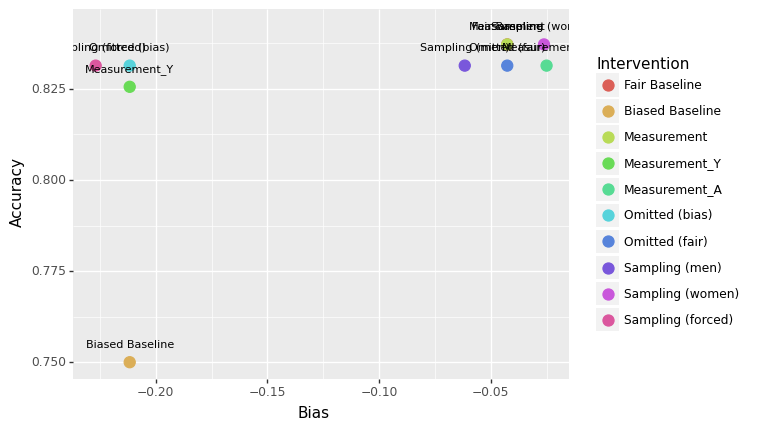

In [53]:
tester = ClassifierTester(ftrain, ftest, btrain, btest)

params = {"measurement": ["studytime", "freetime", "Walc", "goout", "Parents_edu", "absences"],
         "a": "sex",
         "y": "Pass",
         "omit": ["studytime", "freetime", "Parents_edu", "absences", "Walc", "goout", "romantic_no", "romantic_yes", "reason_course", "reason_home", "reason_reputation", "reason_other"]}

performances = tester.test_all_algorithms(params, True)
performances['classifier'] = performances.index
make_scatterplot(performances, "Accuracy", "Bias")

A  Y
0  0    29699
   1    20065
1  0    30206
   1    20030
dtype: int64


TESTING UNFAIR CLASSIFIERS


TESTING FAIR CLASSIFIERS


TESTING MEASUREMENT BIAS


TESTING MEASUREMENT BIAS


TESTING MEASUREMENT BIAS


TESTING OMITTED VARIABLE BIAS


TESTING OMITTED VARIABLE BIAS


TESTING SAMPLING BIAS


TESTING SAMPLING BIAS


TESTING SAMPLING BIAS
                       Bias  Accuracy        F1       AUC  \
Biased Baseline    0.005959   0.78190  0.718508  0.857475   
Fair Baseline      0.005959   0.78190  0.718508  0.857475   
Measurement        0.005959   0.77835  0.706288  0.855956   
Measurement_Y     -0.087878   0.75720  0.628462  0.851012   
Measurement_A      0.003547   0.78240  0.717879  0.857622   
Omitted (bias)     0.005959   0.59455  0.000000  0.499293   
Omitted (fair)     0.005959   0.59455  0.000000  0.499293   
Sampling (men)    -0.022028   0.78090  0.712769  0.857477   
Sampling (women)   0.033783   0.78365  0.717171  0.857139   
Sampling (forced) -0.146862   0.75760  0.62

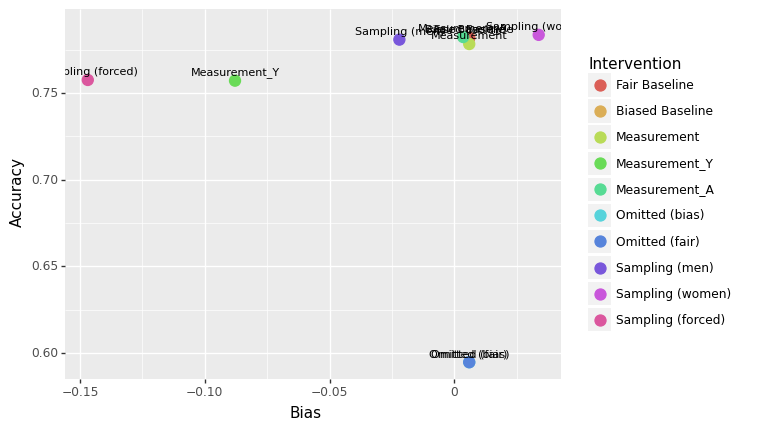

In [56]:
import pickle

with open("data/synthetic/20_x.p", "rb") as f:
    data = pickle.load(f)
    
print(data.df().groupby(["A", "Y"]).size())

train, test = data.split(0.2)

params = {"measurement": [f"X{i}" for i in range(20)],
         "a": "A",
         "y": "Y",
         "omit": [[f"X{i}" for i in range(20)]]}

    
tester = ClassifierTester(train, test, train, test)
performances = tester.test_all_algorithms(params, True)
performances['classifier'] = performances.index
make_scatterplot(performances, "Accuracy", "Bias")